# Distributed Training with Keras

## Import dependencies

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras

import os
print(tf.__version__)

2.3.0


## Dataset - Fashion MNIST

In [6]:
#datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)
#mnist_train, mnist_test = datasets['train'], datasets['test']

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Define a distribution Strategy

In [8]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [9]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [11]:
num_train_examples = len(train_images)#info.splits['train'].num_examples
print(num_train_examples)
num_test_examples = len(test_images)   #info.splits['test'].num_examples
print(num_test_examples)

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

60000
10000


In [13]:
#train_dataset = train_images.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#eval_dataset = test_images.map(scale).batch(BATCH_SIZE)

In [14]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [53]:
with strategy.scope():
  model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer='adam',
                metrics=['accuracy'])

In [54]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [55]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

In [56]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint(ckpt_model, 
#                            monitor='val_accuracy',
#                            verbose=1,
#                            save_best_only=True,
#                            mode='max')

In [58]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [64]:
#model.fit(train_dataset, epochs=12, callbacks=callbacks)
history = model.fit(train_images, train_labels,validation_data=(test_images, test_labels), 
                    epochs=15,callbacks=callbacks)

Epoch 1/15
1840/1875 [============================>.] - ETA: 0s - loss: 0.5935 - accuracy: 0.7878 ETA: 0s - loss: 0.6025 - accu
Learning rate for epoch 1 is 0.0010000000474974513
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5930 - accuracy: 0.7878 - val_loss: 0.5607 - val_accuracy: 0.8050
Epoch 2/15
1835/1875 [============================>.] - ETA: 0s - loss: 0.5369 - accuracy: 0.8128
Learning rate for epoch 2 is 0.0010000000474974513
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5362 - accuracy: 0.8129 - val_loss: 0.5793 - val_accuracy: 0.8014
Epoch 3/15
1840/1875 [============================>.] - ETA: 0s - loss: 0.5291 - accuracy: 0.8174
Learning rate for epoch 3 is 0.0010000000474974513
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5296 - accuracy: 0.8171 - val_loss: 0.6655 - val_accuracy: 0.7981
Epoch 4/15
1844/1875 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8484
Learning rate for epoch 4 

In [70]:
history.history.keys

<function dict.keys>

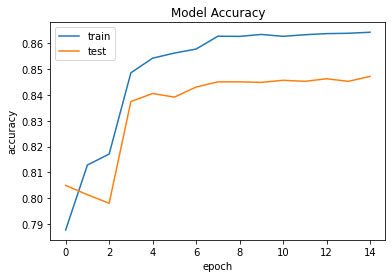

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

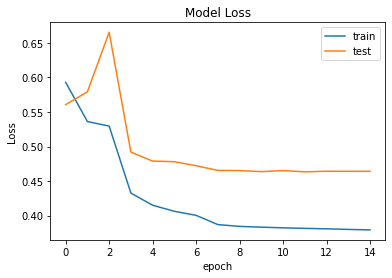

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()